# Cazando al wumpus

In [1]:
# define rutas de trabajo e importa ambiente de trabajo
import os
import sys

CURRENT_PATH = os.getcwd()
NOTEBOOKS_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'notebooks')
PYTHON_PATH = os.path.join(CURRENT_PATH, os.path.pardir, 'python')
sys.path.append(PYTHON_PATH)

from logica import *
from entornos import *
from wkb import *
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt

from busqueda import best_first_search, solucion, breadth_first_search

### Detectando al wumpus

In [4]:
# crea la base de conocimientos de alerta de wumpus

def alerta_wumpus(self):
    x, y = self.loc
    turno = self.turno
    formulas = []
    formulas += [
        f'en({x},{y})_{turno}Yhedor_{turno}>alerta_wumpus({x},{y})',  
    ]
    return formulas

setattr(Agente_wkb, 'alerta_wumpus', alerta_wumpus)


In [5]:
# guarda casillas donde detecto wumpus

def consulta_alerta(self):
	'''
	identifica y retorna las casillas en donde es posible que el wumpus esta.
	Es necesario que la base de conocimientos tenga la cabeza de ASK ya creada.
	'''
	turno = self.turno
	x, y = self.loc

	def truncar(x):
		if x < 0:
			return 0
		elif x > 3:
			return 3
		else:
			return x

	def adyacentes(casilla):
		x, y = casilla
		adyacentes = [
			(truncar(x - 1), y), (truncar(x + 1), y),
			(x, truncar(y - 1)), (x, truncar(y + 1))
		]
		adyacentes = [c for c in adyacentes if c != casilla]
		return adyacentes
	
	casillas = adyacentes(self.loc)
	consulta_alertas = []
	
	consulta = ASK(f'alerta_wumpus({x},{y})', 'success', self.base)
	if consulta:
		for c in casillas:
			x1, y1 = c
			consulta_alertas.append(f'alerta_wumpus({x1},{y1})_{turno}')
			
	return consulta_alertas

setattr(Agente_wkb, 'consulta_alerta', consulta_alerta)

In [6]:
# modifica el metodo `estimar_estado_wkb` para incluir 
# `alerta_wumpus`
# `consulta_alerta`

def estimar_estado_wkb2(self, W):
    self.base.TELL(f'segura({self.loc[0]},{self.loc[1]})')
    cas_seguras = self.adyacentes_seguras_wkb()
    self.base.TELL('Y'.join([f'segura({c[0]},{c[1]})' for c in cas_seguras]))
    nueva_dir = self.nueva_direccion_wkb()
    self.base.TELL(nueva_dir)
    nueva_pos = self.nueva_posicion_wkb()
    self.base.TELL(nueva_pos)
    formulas = [d for d in self.base.datos if f'_{self.turno}' in d]
    formulas += [s for s in self.base.datos if 'segura' in s]
    formulas += self.fluentes_mapa_mental_wkb()
    formulas += self.brisa_pozo_wkb()
    formulas += self.hedor_wumpus_wkb()
    formulas += self.casilla_segura_wkb()
    formulas += self.casillas_visitadas_wkb()
    formulas += self.alerta_wumpus() # new
    self.perceptos = W.para_sentidos()
    formulas += [self.interp_percepto_wkb(mundo='wumpus')]
    self.base = LPQuery(formulas)

setattr(Agente_wkb, 'estimar_estado_wkb', estimar_estado_wkb2)


#### Prueba manual

In [7]:
W = Wumpus(wumpus=(1,1), oro=(2,3), pozos=[(0,3), (3,3)])
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus() # new
formulas += agente.consulta_alerta() # new
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.perceptos = W.para_sentidos()
agente.base = LPQuery(formulas)
print("¡Base de conocimiento creada!")
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)

consulta_alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta

agente.turno += 1
a ='adelante'
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
W.transicion(a)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta() # con la base de conocimiento actual, evalua hedor y crea lista de posibles lugares para el wumpus

agente.turno += 1
a ='adelante'
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
W.transicion(a)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()

agente.turno += 1
a ='voltearIzquierda'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()


agente.turno += 1
a ='adelante'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
agente.estimar_estado_wkb(W)
consulta_alertas += agente.consulta_alerta()

print("***listado de alertas***")
print(consulta_alertas)

¡Base de conocimiento creada!
***listado de alertas***
['alerta_wumpus(0,0)_2', 'alerta_wumpus(2,0)_2', 'alerta_wumpus(1,1)_2', 'alerta_wumpus(1,1)_5', 'alerta_wumpus(3,1)_5', 'alerta_wumpus(2,0)_5', 'alerta_wumpus(2,2)_5']


<AxesSubplot:>

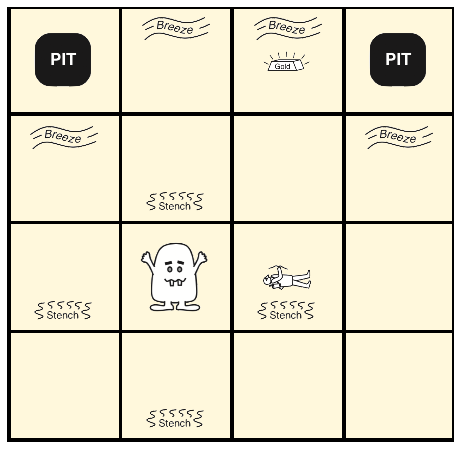

In [8]:
W.pintar_todo()

#### Prueba con programa de agente

In [9]:
# Modifica `lista_alertas`
# - guarda casillas donde detecto wumpus
# - quita turno de las formulas de alerta
# - quita de la lista casillas visitadas

def lista_alertas(self):
	'''
	identifica y retorna las casillas en donde es posible que el wumpus esta.
	Es necesario que la base de conocimientos tenga la cabeza de ASK ya creada.
	'''
	turno = self.turno
	x, y = self.loc

	def truncar(x):
		if x < 0:
			return 0
		elif x > 3:
			return 3
		else:
			return x

	def adyacentes(casilla):
		x, y = casilla
		adyacentes = [
			(truncar(x - 1), y), (truncar(x + 1), y),
			(x, truncar(y - 1)), (x, truncar(y + 1))
		]
		adyacentes = [c for c in adyacentes if c != casilla]
		return adyacentes
	
	casillas = adyacentes(self.loc)
	alertas = []
	
	consulta = ASK(f'alerta_wumpus({x},{y})', 'success', self.base)
	if consulta:
		for c in casillas:
			x1, y1 = c
			alertas.append(f'posible_wumpus({x1},{y1})')
			if c in self.todas_seguras_wkb(): 
				alertas.remove(f'posible_wumpus({x1},{y1})')
			
	return alertas

setattr(Agente_wkb, 'lista_alertas', lista_alertas)

In [10]:
def programaKB(self, DEB=False):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()
    if DEB:
        print('Turno acutal:', turno)
        print('Casilla actual:', casilla_actual)
        print('Dirección actual:', direccion)
        print('Casillas adyacentes seguras:', cas_seguras)
        print('Casillas visitadas:', cas_visitadas)
    if ASK(f'brillo_{turno}','success',self.base):
        if DEB:
            print('¡Oh, el oro!')
    else:
        opciones = [casilla for casilla in cas_seguras if casilla not in cas_visitadas]
        if DEB:
            print('Casillas opcionales:', opciones)
        if len(opciones) > 0:
            print(f"opciones: {opciones}")
            casilla_ir = choice(opciones)
            if DEB:
                print('El agente quiere ir a la casilla', casilla_ir)
            camino = [casilla_actual, casilla_ir]
            acciones = acciones_camino(camino, direccion)
        elif len(cas_seguras) > 0:
            casilla_ir = choice(cas_seguras)
            if DEB:
                print('El agente quiere devolverse a la casilla', casilla_ir)
            camino = [casilla_actual, casilla_ir]
            acciones = acciones_camino(camino, direccion)
        else:
            print("¡Caso no contemplado!")
    self.acciones += acciones

setattr(Agente_wkb, 'programa', programaKB)

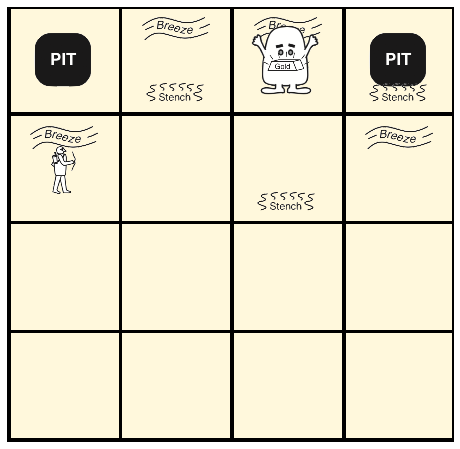

***listado de alertas***
['alerta_wumpus(0,3)_6', 'alerta_wumpus(2,3)_6', 'alerta_wumpus(1,2)_6', 'alerta_wumpus(0,3)_7', 'alerta_wumpus(2,3)_7', 'alerta_wumpus(1,2)_7', 'alerta_wumpus(0,3)_8', 'alerta_wumpus(2,3)_8', 'alerta_wumpus(1,2)_8']


In [11]:

W = Wumpus(wumpus=None, oro=(2,3), pozos=[(0,3), (3,3)])
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)
print("¡Base de conocimiento creada!")

alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta

for i in range(30):
    a = agente.reaccionar_wkb()
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
    if not W.juego_activo:
        clear_output(wait=True)
        W.pintar_todo()
        print(W.mensaje)
        break
    agente.estimar_estado_wkb(W)
    alertas += agente.consulta_alerta()
    clear_output(wait=True)
    W.pintar_todo()
    plt.show()
    sleep(.25) 


print("***listado de alertas***")
print(alertas)

#print("***visitadas***")
#print(agente.todas_seguras_wkb())

## Cazando al wumpus

la casilla con mayor cantidad de alarmas, es la mas probable en donde esté el wumpus.

In [12]:
def identifica_wumpus(self, alertas):
    '''
    Identifica posición mas probable del wumpus e
    identifica los puntos de disparo seguros

    Requiere 
    from collections import Counter
    '''
    c = Counter(alertas)
    c = dict(c)
    prob_wumpus = max(c, key = c.get).replace("posible_wumpus", "")
    prob_wumpus = eval(prob_wumpus)
    print("casilla con alta probabilidad de wumpus: ", prob_wumpus)

    return prob_wumpus

setattr(Agente_wkb, 'identifica_wumpus', identifica_wumpus)


In [13]:
def disparo_seguro(self, prob_wumpus):

    disparo_seguro = []
    for c in self.todas_seguras_wkb(): 
        #print("Puntos seguros de disparo")
        if c[0] == prob_wumpus[0]: 
            #print("x: ", c)
            disparo_seguro.append(c)
        elif c[1] == prob_wumpus[1]: 
            #print("y: ", c)
            disparo_seguro.append(c)
    
    print("Puntos seguros de disparo: ", disparo_seguro)
    return  disparo_seguro  

setattr(Agente_wkb, 'disparo_seguro', disparo_seguro)


In [14]:
def apunta_dir(self, dir_objetivo):
    '''
    Cambia la dirección actual del agente, a la dirección objetivo.
    '''
    dir_direcciones = {'o':'oeste', 'e':'este', 's':'sur', 'n':'norte'}
    print(f"dir actual: {self.solo_direccion_wkb()}")
    acciones_apuntar = voltear(self.solo_direccion_wkb(), dir_direcciones[dir_objetivo])
    print("acciones apuntar: ", acciones_apuntar)
    for accion in acciones_apuntar: 
        #print(self.solo_direccion_wkb())
        self.turno += 1
        W.transicion(accion)
        formula_accion = f'{accion}_{self.turno-1}'
        self.base.TELL(formula_accion)
        self.estimar_estado_wkb(W)
        print(self.solo_direccion_wkb())
    print(f"dir final: {self.solo_direccion_wkb()}")
    
setattr(Agente_wkb, 'apunta_dir', apunta_dir)


In [15]:
def apunta(self, prob_wumpus):
    '''
    Cambia la dirección del agente a la dirección apropiada para disparar al wumpus
    '''
    print(f"prob_wumpus: {prob_wumpus}")
    x_agente, y_agente = self.loc
    x_wumpus, y_wumpus = prob_wumpus

    if x_agente < x_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta este
        self.apunta_dir('e')
    elif x_agente > x_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta oeste
        self.apunta_dir('o')
    elif y_agente < y_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta norte
        self.apunta_dir('n')
    elif y_agente > y_wumpus: 
        print(f"pos_agente: {self.loc}, dir: {self.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
        ## apunta sur
        self.apunta_dir('s')
    else:
        print("no fue posible apuntar")

    W.pintar_todo()
    plt.show()

setattr(Agente_wkb, 'apunta', apunta)

In [16]:
def casilla_apunta(self, disparo_seguro): 
    '''
    Se dirige a una casilla segura para apuntar
    '''
#    disparo_seguro = self.disparo_seguro(alertas)
    print("se dirige a casilla segura")

    if self.loc in disparo_seguro: 
        clear_output(wait=True)
        print("Listo para disparar")
        W.pintar_todo()
        plt.show()
        return None
    
    else:
        print("ir a casilla de disparo")
        acciones = []
        turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()
        R = Rejilla(self.loc, choice(disparo_seguro), self.todas_seguras_wkb())
        camino = best_first_search(R)
        camino = [self.loc] + solucion(camino)
        acciones += acciones_camino(camino, direccion)

    #self.acciones += acciones
        
        for accion in acciones: 
            #print(self.solo_direccion_wkb())
            self.turno += 1
            W.transicion(accion)
            formula_accion = f'{accion}_{self.turno-1}'
            self.base.TELL(formula_accion)
            self.estimar_estado_wkb(W)
            clear_output(wait=True)
            W.pintar_todo()
            plt.show()
            sleep(.5) 
    print("en posicion de disparo")
    print(f"ubiación final del self: {self.loc}")
    print(f"dir final: ", {self.solo_direccion_wkb()})

setattr(Agente_wkb, 'casilla_apunta', casilla_apunta)

In [17]:
def explorar(self):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()

    opciones = [casilla for casilla in cas_seguras if casilla not in cas_visitadas]
    
    if len(opciones) > 0:
        print(f"opciones: {opciones}")
        casilla_ir = choice(opciones)
        camino = [casilla_actual, casilla_ir]
        acciones = acciones_camino(camino, direccion)
    elif len(cas_seguras) > 0:
        casilla_ir = choice(cas_seguras)
        camino = [casilla_actual, casilla_ir]
        acciones = acciones_camino(camino, direccion)
    else:
        print("¡Caso no contemplado!")
        
    self.acciones += acciones 

setattr(Agente_wkb, 'explorar', explorar)

## **Construcción programa agente**

In [18]:
def programaKB(self, DEB=False):
    acciones = []
    turno, casilla_actual, direccion, cas_seguras, cas_visitadas = self.cache_wkb()

    self.explorar()
    #print("¡Cuidado! Wumpus vivo")
    #self.lista_alertas() # recorre el laberinto identificando alertas wumpus
    # prob_wumpus = self.identifica_wumpus(alertas) # identifica posible lugar wumpus
    # self.disparo_seguro(prob_wumpus) # encuentra lugares seguros de disparo
    # self.casilla_apunta(alertas) # se dirige a la casilla de disparo
    # self.apunta(prob_wumpus)
    # acciones.append('disparar')
    # print("¡El wumpus ha caido!")

        # cazar!
        
    # if not W.wumpus_vivo: 
    #     print("El wumpus esta sin vida...")
        # buscar oro y salir
        # modificar base de conocimiento para que wumpusmuerto y hedor -> seguro

setattr(Agente_wkb, 'programa', programaKB)

In [20]:
# codigo de ejecución 

W = Wumpus(wumpus = None, oro = None, pozos = None)
agente = Agente_wkb()
formulas = agente.fluentes_mapa_mental_wkb()
formulas += agente.brisa_pozo_wkb()
formulas += agente.hedor_wumpus_wkb()
formulas += agente.casilla_segura_wkb()
formulas += agente.alerta_wumpus()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto_wkb(mundo='wumpus')
agente.base.TELL(c)
print("¡Base de conocimiento creada!")

def explorar_lab():
    alertas = [] # lista que guarda las casillas en donde es probable que el wumpus esta
    for i in range(40):
        a = agente.reaccionar_wkb()
        formula_accion = f'{a}_{agente.turno-1}'
        agente.base.TELL(formula_accion)
        W.transicion(a)
        if not W.juego_activo:
            clear_output(wait=True)
            W.pintar_todo()
            print(W.mensaje)
            break
        agente.estimar_estado_wkb(W)
        alertas += agente.lista_alertas()
        clear_output(wait=True)
        W.pintar_todo()
        plt.show()
        sleep(.25) 

    return alertas

alertas = explorar_lab()
prob_wumpus = agente.identifica_wumpus(alertas)
disparo_seguro = agente.disparo_seguro(prob_wumpus) # encuentra lugares seguros de disparo
agente.casilla_apunta(disparo_seguro)
agente.apunta(prob_wumpus) # se dirige a la casilla de disparo

print("listo para disparar")
agente.turno += 1
a = 'disparar'
W.transicion(a)
formula_accion = f'{a}_{agente.turno-1}'
agente.base.TELL(formula_accion)
#agente.estimar_estado_wkb(W)

if not W.wumpus_vivo: 
    print("¡El wumpus ha sido impactado!")

else: 
    print("intento fallido. Wumpus vivo. :v")

ValueError: list.remove(x): x not in list

- Mejorar metodos de la clase
- exploracion y caza, deben retornar acciones
- el bucle se repite según la cantidad de acciones disponibles para el agente
- el programa de agente: primero caza, luego sale con el oro. 

In [202]:
l= [1,2,3,4,5,6,7]
l.remove(7)
l

[1, 2, 3, 4, 5, 6]

## Construcción de funciones

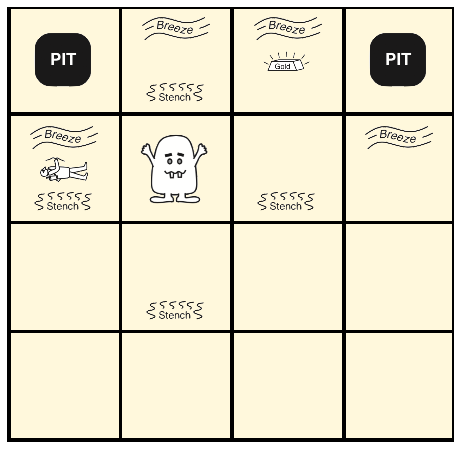

dir final:  norte
ubiación final del agente: (0, 2)


In [65]:
disparo_seguro = agente.disparo_seguro(consulta_alertas)

acciones = []
turno, casilla_actual, direccion, cas_seguras, cas_visitadas = agente.cache_wkb()
R = Rejilla(agente.loc, choice(disparo_seguro), agente.todas_seguras_wkb())
camino = best_first_search(R)
camino = [agente.loc] + solucion(camino)
acciones += acciones_camino(camino, direccion)

for accion in acciones: 
    #print(agente.solo_direccion_wkb())
    agente.turno += 1
    W.transicion(accion)
    formula_accion = f'{accion}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    agente.estimar_estado_wkb(W)
    clear_output(wait=True)
    W.pintar_todo()
    plt.show()
    sleep(.5) 

print("dir final: ", agente.solo_direccion_wkb())
print(f"ubiación final del agente: {agente.loc}")



In [48]:
# puntos seguros de disparo

from collections import Counter


c = Counter(consulta_alertas)
c = dict(c)
prob_wumpus = max(c, key = c.get).replace("posible_wumpus", "")
prob_wumpus = eval(prob_wumpus)
print("casilla con alta probabilidad de wumpus: ", prob_wumpus)

disparo_seguro = []
for c in agente.todas_seguras_wkb(): 
    #print("Puntos seguros de disparo")
    if c[0] == prob_wumpus[0]: 
        #print("x: ", c)
        disparo_seguro.append(c)
    elif c[1] == prob_wumpus[1]: 
        #print("y: ", c)
        disparo_seguro.append(c)

print("Puntos seguros de disparo: ", disparo_seguro)

casilla con alta probabilidad de wumpus:  (1, 2)
Puntos seguros de disparo:  [(0, 2), (1, 0), (1, 1), (2, 2), (3, 2)]


In [ ]:
x_agente, y_agente = agente.loc
x_wumpus, y_wumpus = prob_wumpus

if x_agente == x_wumpus - 1: 
    print(f"pos_agente: {agente.loc}, dir: {agente.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
    ## apunta este
    agente.apunta('e')
elif x_agente == x_wumpus + 1: 
    print(f"pos_agente: {agente.loc}, dir: {agente.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
    ## apunta oeste
    agente.apunta('o')
elif y_agente == y_wumpus - 1: 
    print(f"pos_agente: {agente.loc}, dir: {agente.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
    ## apunta norte
    agente.apunta('n')
elif y_agente == y_wumpus + 1: 
    print(f"pos_agente: {agente.loc}, dir: {agente.solo_direccion_wkb()} - pos_wumpus: {prob_wumpus}")
    ## apunta sur
    agente.apunta('s')

In [14]:
dir_direcciones = {'o':'oeste', 'e':'este', 's':'sur', 'n':'norte'}
dir_objetivo = 'n'
print("dir actual: ", agente.solo_direccion_wkb())
acciones_apuntar = voltear(agente.solo_direccion_wkb(), dir_direcciones[dir_objetivo])
print("acciones apuntar: ", acciones_apuntar)
for accion in acciones_apuntar: 
    #print(agente.solo_direccion_wkb())
    agente.turno += 1
    W.transicion(accion)
    formula_accion = f'{accion}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    agente.estimar_estado_wkb(W)
    print(agente.solo_direccion_wkb())
print("dir final: ", agente.solo_direccion_wkb())


dir actual:  sur
acciones apuntar:  ['voltearIzquierda', 'voltearIzquierda']
este
norte
dir final:  norte
